# Pollutions

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import random
import seaborn as sns
from tqdm import tqdm

from src.tools.plotter import init_plots, store_sns

init_plots()

### General changes

- Using numpy array indexing instead of appending python list (speed increase)
- Computes (too much) random values all at once. This results in a major speed increase.

In [2]:
A = 5
B = 3
DELAY_AMP = 10
GAUSS_LEVEL = 8
CLOCK_VAR = 1 # 2 in the original, with random int.

WIN_CALC = 2

### Clock jitter implementation

Differences in implementation from AISY lab:
- Changed `random.randint` to `random.normal`, to better simulate a real-world process.

In [14]:
RAW_TRACES = np.array([(np.sin(np.linspace(1, 20, 2000)) * 100) for _ in range(100)], dtype=np.int8)
RAW_TRACES_MAX = np.array([(np.sin(np.linspace(1, 20, 2000)) * np.iinfo(np.int8).max) for _ in range(100)], dtype=np.int8)

WINDOW = (500, 1500)

TRACES = RAW_TRACES[:, WINDOW[0]:WINDOW[1]]
TRACES_MAX = RAW_TRACES_MAX[:, WINDOW[0]:WINDOW[1]]

Clock jitter: 100%|██████████| 100/100 [00:00<00:00, 1044.53it/s]


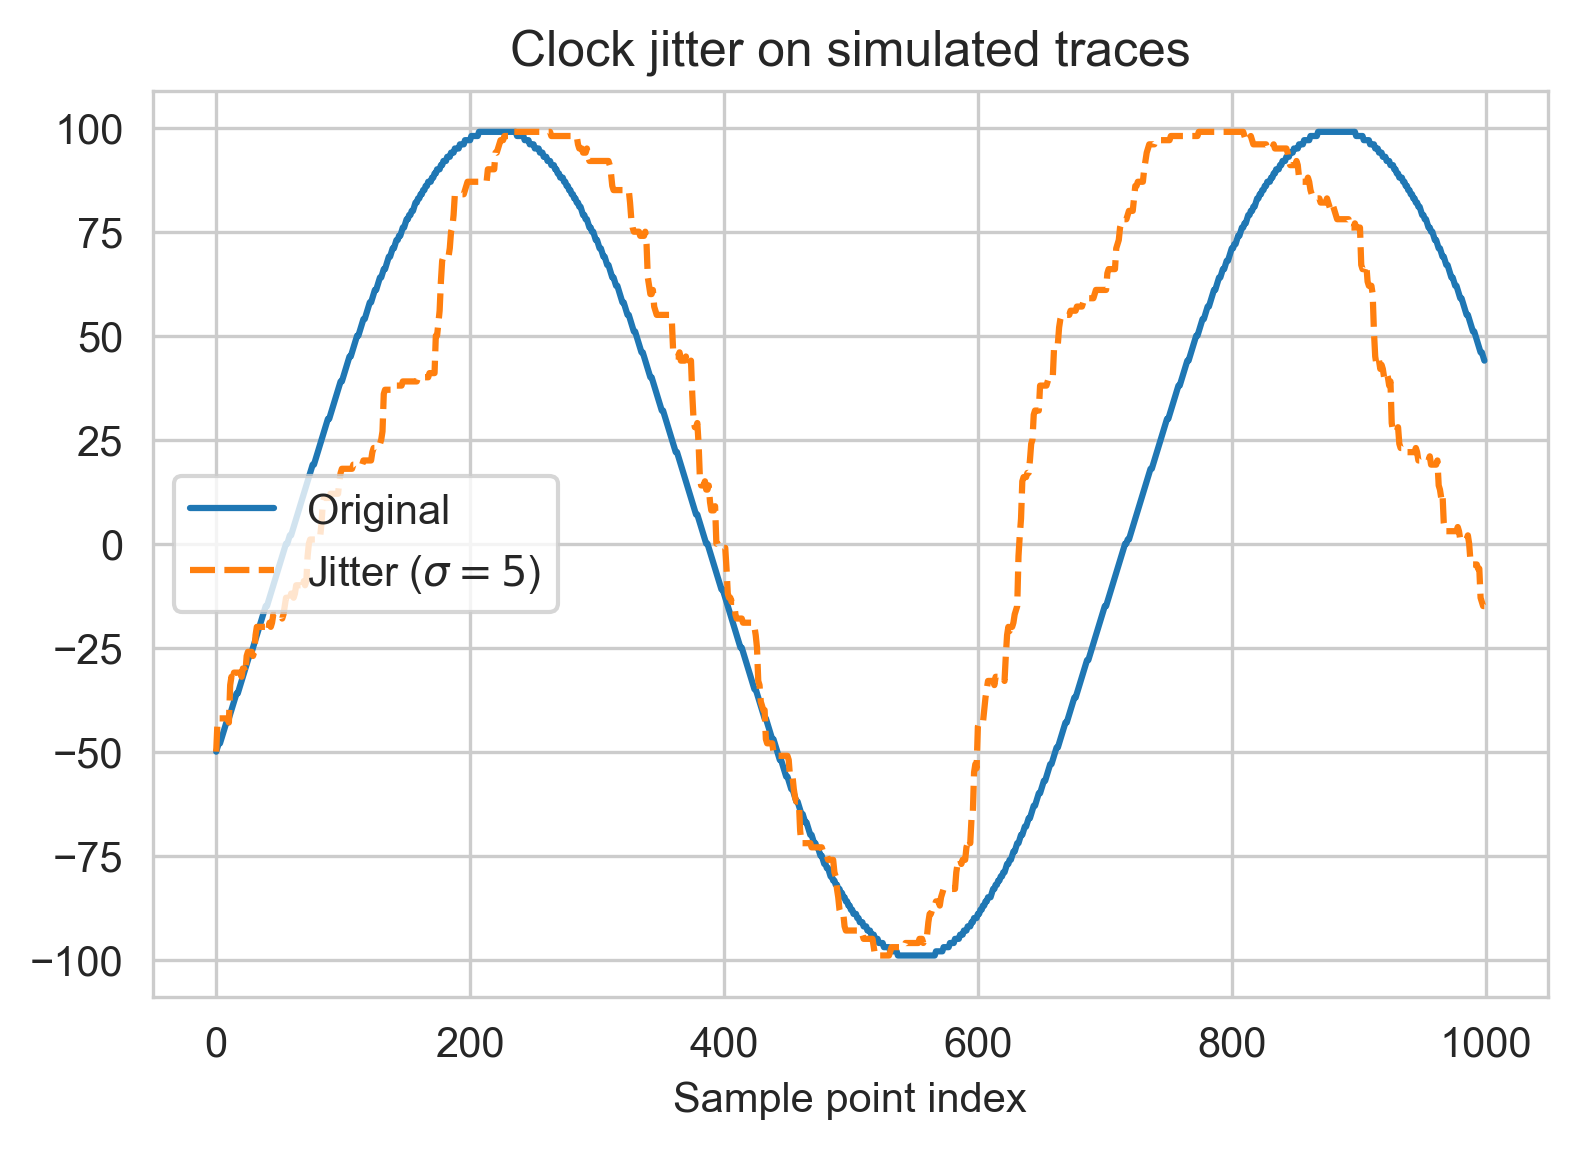

In [4]:
def windowed(raw_traces: np.ndarray, window: (int, int), calculate_win = 2):
    wa, wb = window
    win_size = wb - wa

    traces = raw_traces[:, wa:wb + win_size * calculate_win]
    return traces, win_size


def clock_jitter(raw_traces: np.ndarray, window: (int, int), clock_var: float):
    traces, win_size = windowed(raw_traces, window)
    num_traces, trace_length = traces.shape

    res = np.zeros_like(traces)
    min_trace_len = trace_length

    for ix, trace in tqdm(enumerate(traces), total=num_traces, desc="Clock jitter"):
        sp_old, sp_new = 0, 0

        # Computing (too much) random variables all at once yields a ~1.5x speed increase.
        jitters = random.normal(scale=clock_var, size=trace_length).astype(int)

        while sp_new < trace_length and sp_old < trace_length:
            r = jitters[sp_new]

            res[ix, sp_new] = trace[sp_old]
            sp_old += 1
            sp_new += 1

            sp_old_r = sp_old - r
            sp_new_r = sp_new + r
            if sp_old_r > trace_length or sp_new_r > trace_length or sp_old + 1 >= trace_length:
                break

            # if r < 0, delete r point afterward
            if r <= 0:
                sp_old = sp_old_r
            # if r > 0, add r point afterward
            else:
                avg_point = (int(trace[sp_old]) + int(trace[sp_old + 1])) / 2
                res[ix, sp_new:sp_new_r] = avg_point
                sp_new = sp_new_r

        min_trace_len = min(sp_new, min_trace_len)

    return res[:, :win_size]

DEMO_CLOCK_VAR = 5
JITTER = clock_jitter(RAW_TRACES, WINDOW, DEMO_CLOCK_VAR)
G = sns.lineplot(data={"Original": TRACES[0], f"Jitter ($\sigma = {DEMO_CLOCK_VAR}$)": JITTER[0]})
G.set(title="Clock jitter on simulated traces", xlabel="Sample point index")
store_sns(G, "pollution_jitter")

plt.legend(loc='center left')

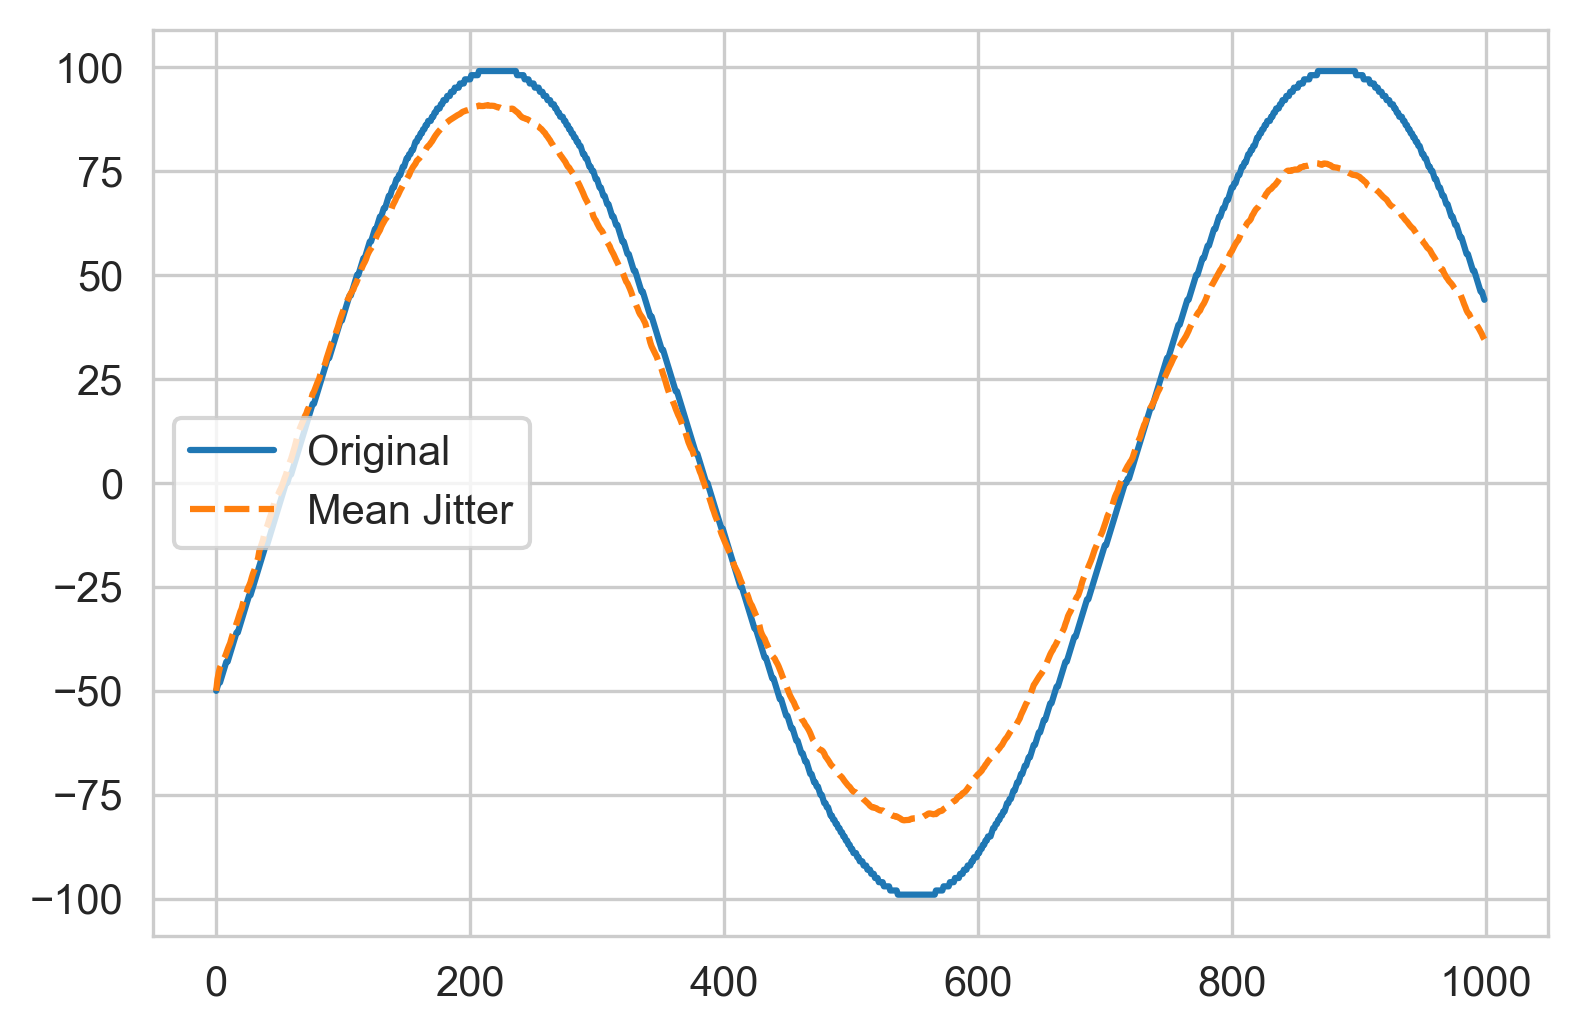

In [5]:
sns.lineplot(data={"Original": TRACES[0], "Mean Jitter": np.mean(JITTER,axis=0)})
plt.legend(loc='center left')

### Random delay implementation

Differences in implementation from AISY lab:
- Sample point value capped at 127, which is the maximum value of `np.int8`. This prevents integer overflow issues after
applying the `delay_amplitude`.
- Variable delay probability.

Random delay: 100%|██████████| 100/100 [00:00<00:00, 1766.74it/s]


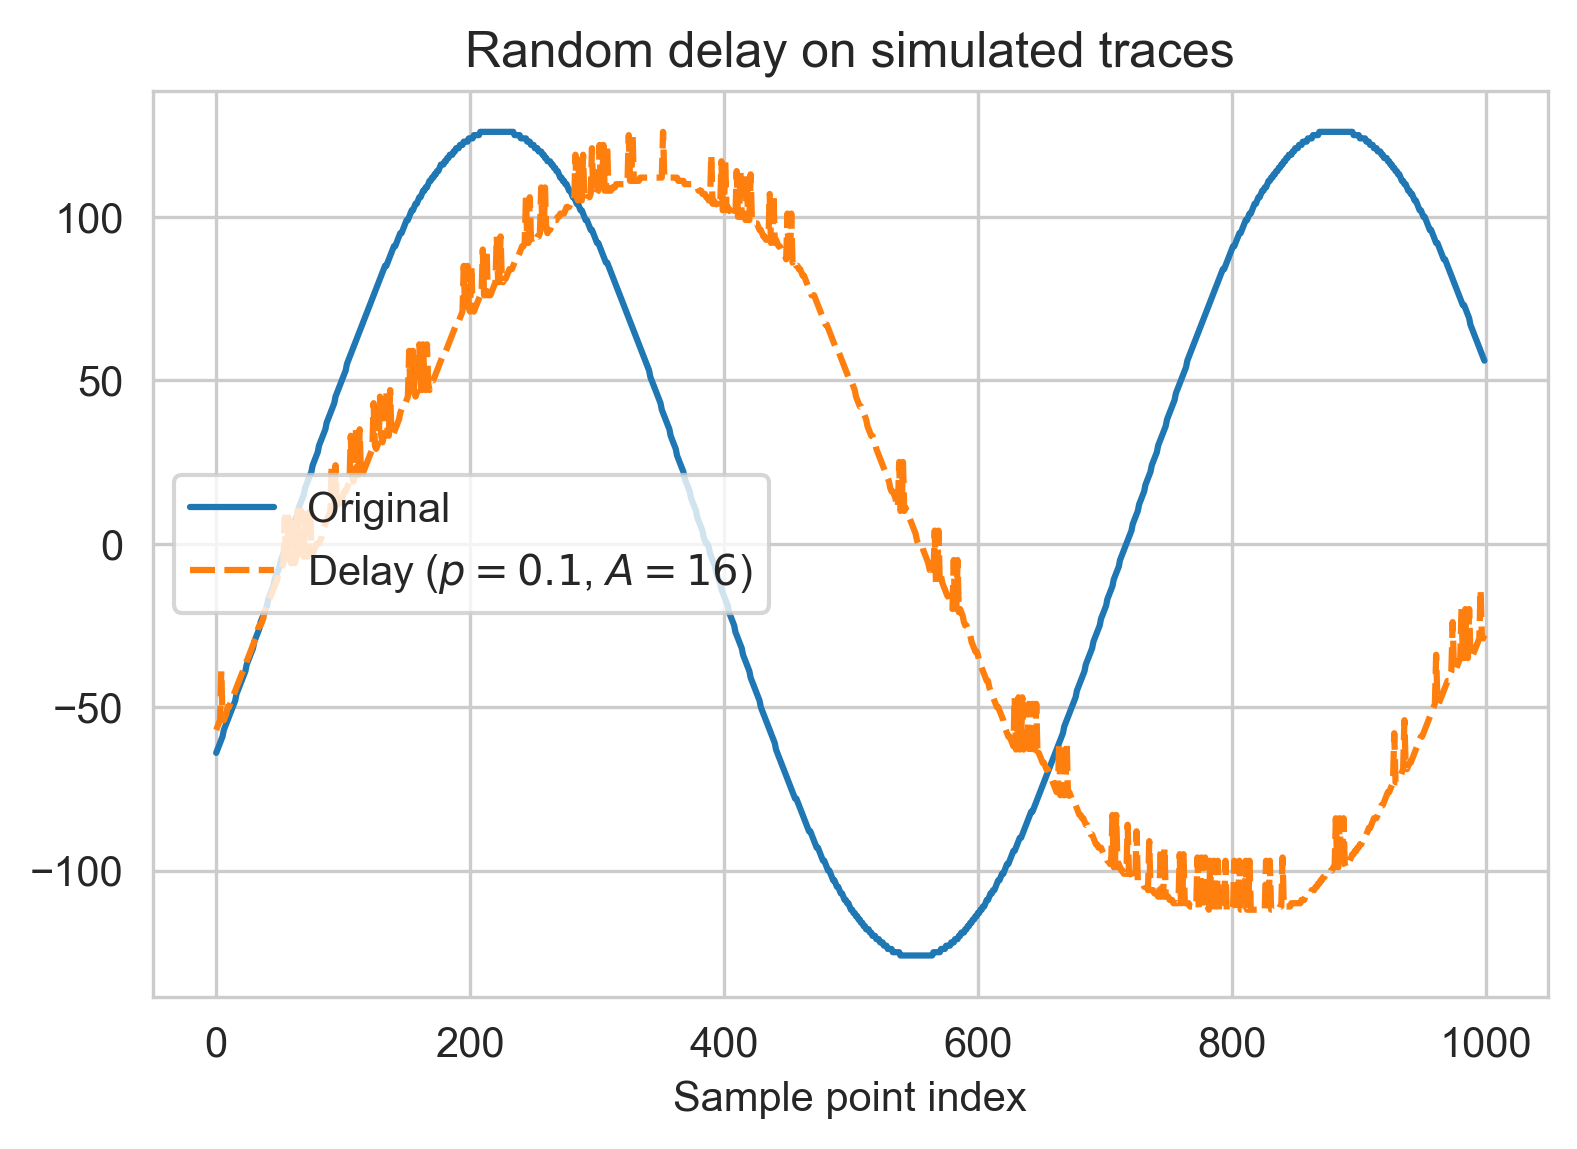

In [57]:
def random_delay(traces, a, b, delay_amplitude, delay_probability=.5):
    res = np.zeros_like(traces)
    num_traces, trace_length = traces.shape

    max_sp_data = np.iinfo(traces.dtype).max
    max_sp = np.max(traces)
    norm_factor = max_sp_data / (max_sp + delay_amplitude)
    if norm_factor < 1:
        traces = np.array(norm_factor * traces, dtype=traces.dtype)
        delay_amplitude *= norm_factor

    for ix, trace in tqdm(enumerate(traces), total=num_traces, desc="Random delay"):
        sp_old, sp_new = 0, 0

        # Computing (too much) random variables all at once yields >2x speed increase.
        do_jitter = random.binomial(1, delay_probability, trace_length)
        lower_bound = random.randint(0, a - b, size=trace_length)
        upper_bound = random.randint(0, b, size=trace_length) + lower_bound

        while sp_new < trace_length and sp_old < trace_length:
            r = do_jitter[sp_new]

            res[ix, sp_new] = trace[sp_old]
            sp_old += 1
            sp_new += 1

            if r:
                for _ in range(upper_bound[sp_old]):
                    if sp_new + 3 > trace_length:
                        continue

                    spike = trace[sp_old] + delay_amplitude
                    delay_sequence = [trace[sp_old], spike, trace[sp_old + 1]]
                    res[ix, sp_new:sp_new + 3] = delay_sequence
                    sp_new += 3

    return res

In [ ]:
DELAY_PROB = .1
DELAY = random_delay(TRACES, A, B, DELAY_AMP, DELAY_PROB)
G = sns.lineplot(data={"Original": TRACES[0], f"Delay ($p ={DELAY_PROB}$)": DELAY[0]})
G.set(title="Random delay on simulated traces", xlabel="Sample point index")
store_sns(G, "pollution-delay")

plt.legend(loc='center left')

In [ ]:
DELAY_MAX = random_delay(TRACES_MAX, A, B, 16, DELAY_PROB)
G = sns.lineplot(data={"Original": TRACES_MAX[0], f"Delay ($p ={DELAY_PROB}$, $A = 16$)": DELAY_MAX[0]})
G.set(title="Random delay on simulated traces", xlabel="Sample point index")
store_sns(G, "pollution-delay-normalised")

plt.legend(loc='center left')

In [7]:
np.iinfo(np.int8).max

127

### Random delay implementation

No differences other than simplification.

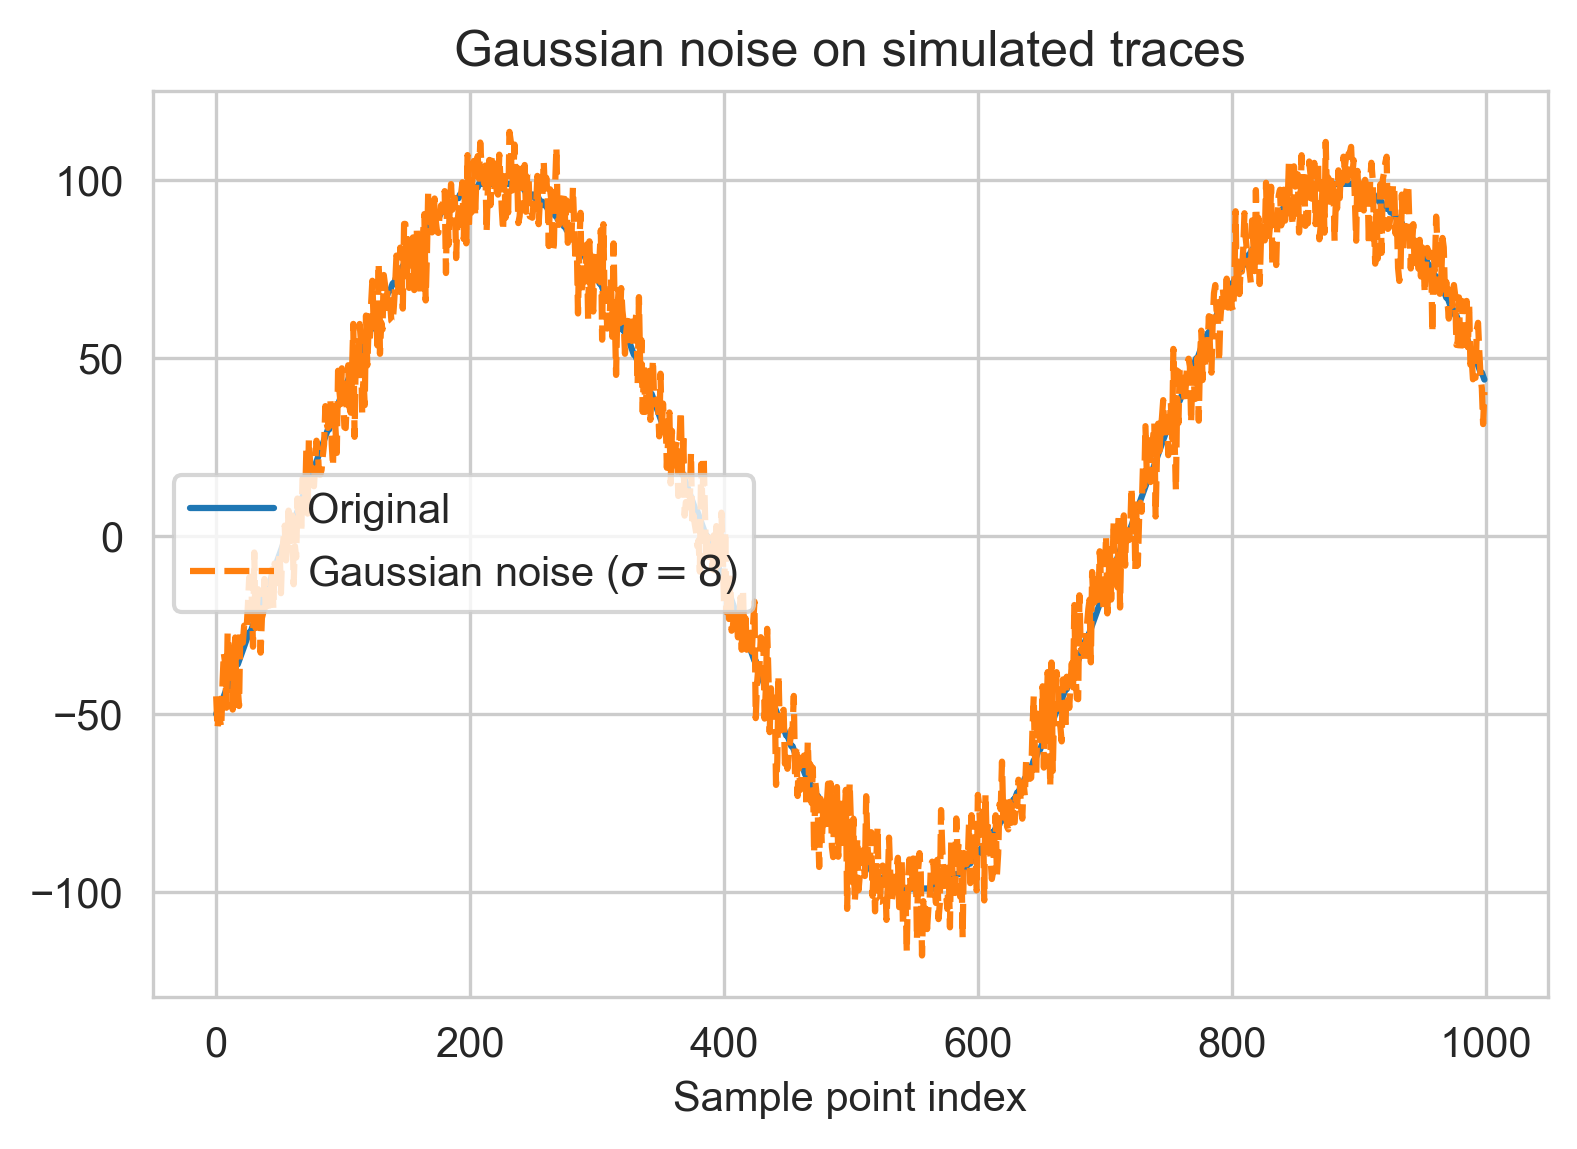

In [8]:
def gaussian_noise(traces, noise_level):
    return traces + random.normal(scale=noise_level, size=traces.shape)

GAUSSIAN = gaussian_noise(TRACES, GAUSS_LEVEL)
G = sns.lineplot(data={"Original": TRACES[0], f"Gaussian noise ($\sigma = {GAUSS_LEVEL}$)": GAUSSIAN[0]})
G.set(title="Gaussian noise on simulated traces", xlabel="Sample point index")
store_sns(G, "pollution_gauss")

plt.legend(loc='center left')

### Window jitter implementation

Based on the method from ASCAD.

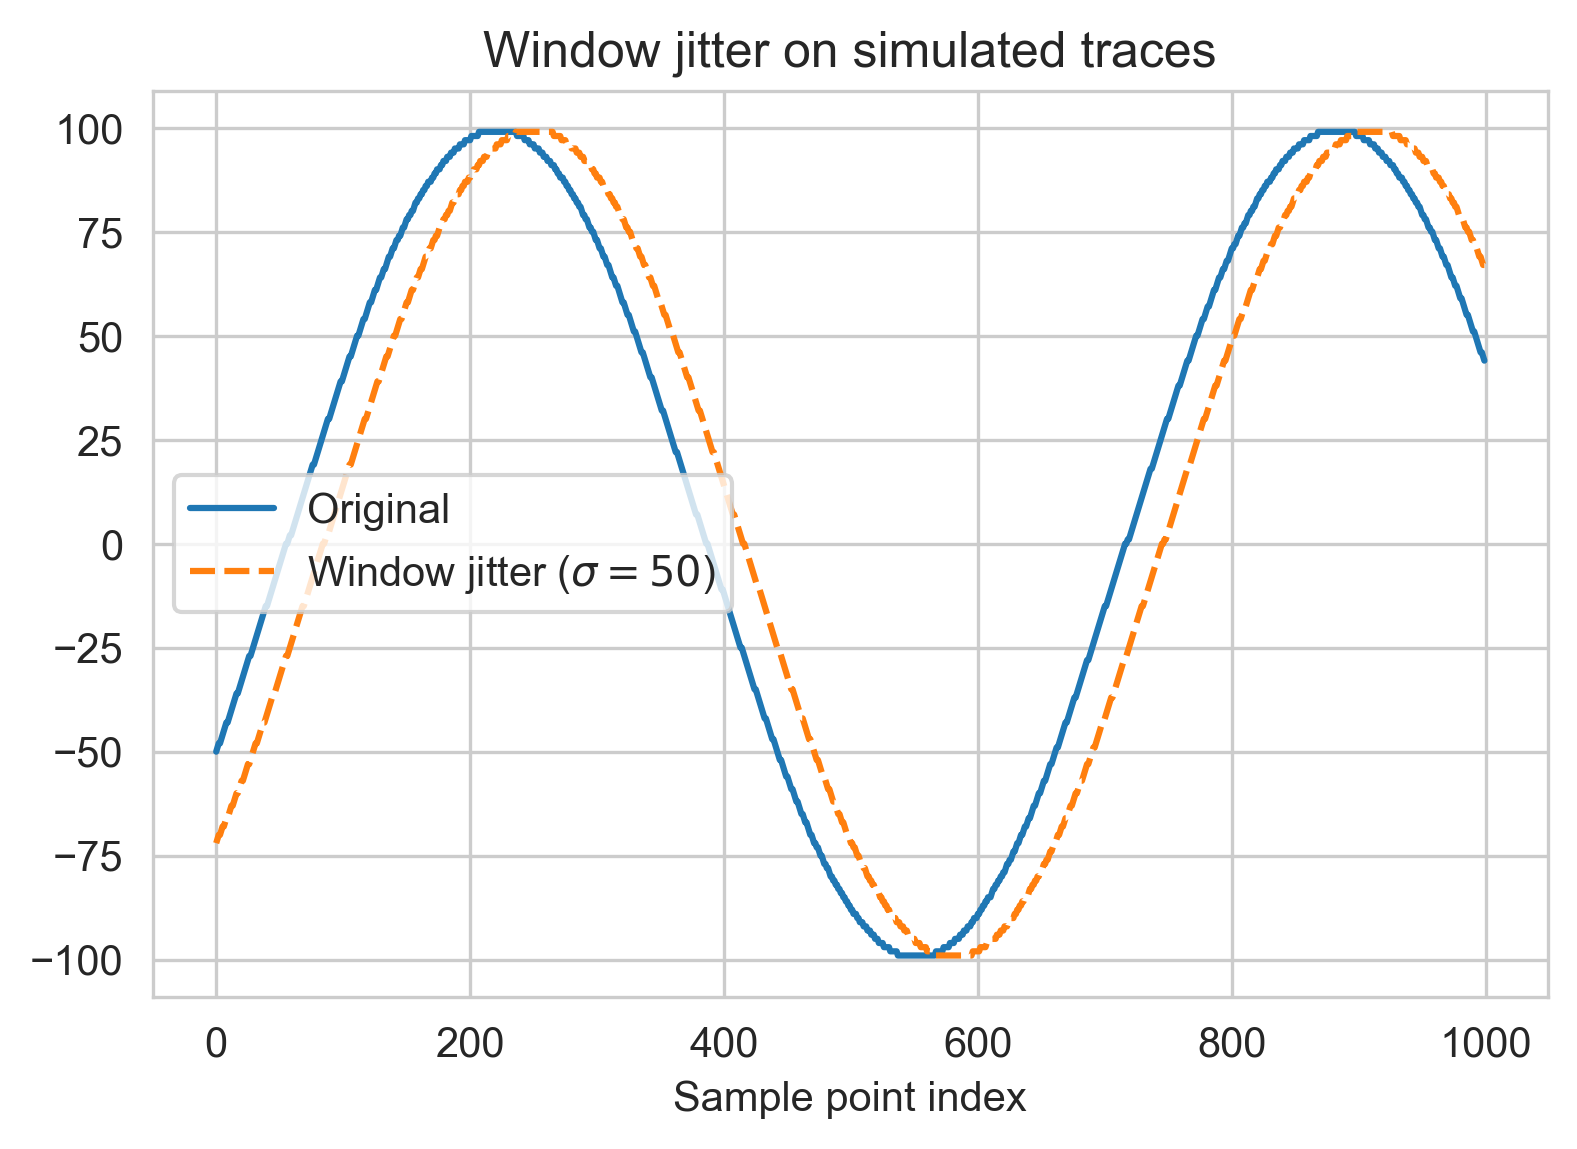

In [9]:
WINDOW_JITTER = 50

def window_jitter(raw_traces: np.ndarray, window: (int, int), noise_level: float):
    wa, wb = window
    window_length = wb - wa
    num_traces, trace_len = raw_traces.shape
    jitter_start = random.normal(scale=noise_level, size=num_traces).astype(int)

    res = np.zeros((num_traces, window_length), dtype=np.int8)
    for ix, trace in enumerate(raw_traces):
        offset = jitter_start[ix]
        res[ix] = trace[wa + offset:wb + offset]

    return res

WIN_JITTER = window_jitter(RAW_TRACES, WINDOW, WINDOW_JITTER)
G = sns.lineplot(data={"Original": TRACES[0], f"Window jitter ($\sigma = {WINDOW_JITTER}$)": WIN_JITTER[0]})
G.set(title="Window jitter on simulated traces", xlabel="Sample point index")
store_sns(G, "pollution_desync")

plt.legend(loc='center left')